In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import List

# **DATA GENERATION**

In [3]:
N_SAMPLES = 5000
N_POINTS = 100          # points per geometry
DOMAIN_MIN, DOMAIN_MAX = 0.0, 1.0
SEED = 42

np.random.seed(SEED)

# -----------------------------
# Sampling functions
# -----------------------------
def sample_material_parameters():
    Ex = np.random.uniform(5.0, 20.0)
    Ey = np.random.uniform(5.0, 20.0)
    nu_xy = np.random.uniform(0.15, 0.35)

    # Equation (20) from paper
    Gxy = (Ex / (2 * (1 + nu_xy))) * (Ey / (2 * (1 + nu_xy)))

    return Ex, Ey, nu_xy, Gxy


def sample_traction():
    tx = np.random.uniform(-0.3, 0.3)
    ty = np.random.uniform(-0.3, 0.3)
    return tx, ty


def sample_coordinates(n_points):
    x = np.random.uniform(DOMAIN_MIN, DOMAIN_MAX, n_points)
    y = np.random.uniform(DOMAIN_MIN, DOMAIN_MAX, n_points)
    return np.stack([x, y], axis=1)


def compute_ux(coords, tx, ty, Ex, Ey, nu_xy, Gxy):
    """
    Physics-inspired analytical displacement field
    """
    x = coords[:, 0]
    y = coords[:, 1]

    ux = (
        (tx / Ex) * x * (1 - x) * y
        + (ty / Gxy) * x * y * (1 - y)
    )

    return ux.reshape(-1, 1)


# Dataset generation
branch_inputs = np.zeros((N_SAMPLES, 6))
trunk_inputs = np.zeros((N_SAMPLES, N_POINTS, 2))
ux_targets = np.zeros((N_SAMPLES, N_POINTS, 1))

for i in range(N_SAMPLES):
    # Sample parameters
    tx, ty = sample_traction()
    Ex, Ey, nu_xy, Gxy = sample_material_parameters()

    branch_inputs[i] = [tx, ty, Ex, Ey, nu_xy, Gxy]

    coords = sample_coordinates(N_POINTS)
    trunk_inputs[i] = coords

    ux_targets[i] = compute_ux(
        coords, tx, ty, Ex, Ey, nu_xy, Gxy
    )

# Train-test split
split = int(0.8 * N_SAMPLES)

branch_train, branch_test = branch_inputs[:split], branch_inputs[split:]
trunk_train, trunk_test = trunk_inputs[:split], trunk_inputs[split:]
ux_train, ux_test = ux_targets[:split], ux_targets[split:]

print("Branch input shape:", branch_train.shape)
print("Trunk input shape:", trunk_train.shape)
print("Target ux shape:", ux_train.shape)


Branch input shape: (4000, 6)
Trunk input shape: (4000, 100, 2)
Target ux shape: (4000, 100, 1)


# **DEEPOKAN**

In [ ]:
class RadialBasisFunctionNetwork(nn.Module):
    def __init__(self, hidden_layers: List[int], min_grid: float = -1., max_grid: float = 1., grid_count: int = 5, apply_base_update: bool = False, activation: nn.Module = nn.SiLU(), grid_opt: bool = False, dtype: torch.dtype = torch.float32, noise_scale: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList()
        # First layer with specified min_grid and max_grid
        self.layers.append(RadialBasisFunctionLayer(hidden_layers[0], hidden_layers[1], min_grid, max_grid, grid_count, apply_base_update, activation, grid_opt, dtype, noise_scale))
        # Subsequent layers with min_grid and max_grid set to -1 and 1
        for in_dim, out_dim in zip(hidden_layers[1:-1], hidden_layers[2:]):
            self.layers.append(RadialBasisFunctionLayer(in_dim, out_dim, -1., 1., grid_count, apply_base_update, activation, grid_opt, dtype, noise_scale))
        self.dtype = dtype

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.dtype)
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

class RadialBasisFunctionLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, min_grid: float = -1., max_grid: float = 1., grid_count: int = 5, apply_base_update: bool = False, activation: nn.Module = nn.SiLU(), grid_opt: bool = False, dtype: torch.dtype = torch.float32, noise_scale: float = 0.1):
        super().__init__()
        self.apply_base_update = apply_base_update
        self.activation = activation
        self.min_grid = min_grid
        self.max_grid = max_grid
        self.grid_count = grid_count
        self.grid = nn.Parameter(torch.linspace(min_grid, max_grid, grid_count, dtype=dtype), requires_grad=grid_opt)
        self.rbf_weight = nn.Parameter(torch.empty(in_features * grid_count, out_features, dtype=dtype))
        self.scale_base = nn.Parameter(torch.ones(out_features, dtype=dtype))
        self.scale_rbf = nn.Parameter(torch.ones(out_features, dtype=dtype))

        nn.init.xavier_normal_(self.rbf_weight)
        self.rbf_weight.data += torch.randn_like(self.rbf_weight) * noise_scale

        self.base_activation = nn.SiLU() if apply_base_update else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.rbf_weight.dtype)
        x_unsqueezed = x.unsqueeze(-1)
        rbf_basis = torch.exp(-((x_unsqueezed - self.grid) / ((self.max_grid - self.min_grid) / (self.grid_count - 1))) ** 2)  # Shape: (batch_size, in_features, grid_count)
        rbf_basis = rbf_basis.view(rbf_basis.size(0), -1)  # Shape: (batch_size, in_features * grid_count)

        rbf_output = torch.mm(rbf_basis, self.rbf_weight)  # Shape: (batch_size, out_features)

        if self.apply_base_update:
            # Compute base activation if required
            base_output = self.base_activation(x)
            base_output = base_output.mean(dim=-1, keepdim=True)
            output = self.scale_base * base_output + self.scale_rbf * rbf_output
        else:
            output = self.scale_rbf * rbf_output

        return output

In [5]:
class BranchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = RadialBasisFunctionNetwork(
            hidden_layers=[6, 6, 6, 4],  # 2 hidden layers of width 6
            min_grid=-1.0,
            max_grid=1.0,
            grid_count=5
        )

    def forward(self, x):
        return self.net(x)


In [7]:
class TrunkNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = RadialBasisFunctionNetwork(
            hidden_layers=[2, 6, 6, 4],
            min_grid=0.0,
            max_grid=1.0,
            grid_count=5
        )

    def forward(self, x):
        return self.net(x)


In [8]:
class DeepOKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = BranchNet()
        self.trunk = TrunkNet()

    def forward(self, branch_input, trunk_input):
        """
        branch_input: (batch, 6)
        trunk_input:  (batch, N_POINTS, 2)
        """
        B = branch_input.shape[0]
        N = trunk_input.shape[1]

        # Branch output
        b = self.branch(branch_input)               # (B, 4)
        b = b.unsqueeze(1).expand(-1, N, -1)        # (B, N, 4)

        # Trunk output
        t = self.trunk(trunk_input.reshape(-1, 2))  # (B*N, 4)
        t = t.view(B, N, 4)

        # Dot product
        ux_pred = torch.sum(b * t, dim=-1, keepdim=True)  # (B, N, 1)
        return ux_pred


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
branch_train_t = torch.tensor(branch_train, dtype=torch.float32).to(device)
trunk_train_t  = torch.tensor(trunk_train, dtype=torch.float32).to(device)
ux_train_t     = torch.tensor(ux_train, dtype=torch.float32).to(device)

branch_test_t = torch.tensor(branch_test, dtype=torch.float32).to(device)
trunk_test_t  = torch.tensor(trunk_test, dtype=torch.float32).to(device)
ux_test_t     = torch.tensor(ux_test, dtype=torch.float32).to(device)

In [139]:
model_1 = DeepOKAN().to(device)

optimizer = optim.Adam(model_1.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=500,
    gamma=0.5
)

epochs = 5000
rmsd_history = []


In [83]:
def rmsd(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))


In [140]:
for epoch in range(epochs):
    model_1.train()
    optimizer.zero_grad()

    ux_pred = model_1(branch_train_t, trunk_train_t)
    loss = rmsd(ux_pred, ux_train_t)

    loss.backward()
    optimizer.step()
    scheduler.step()

    rmsd_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | RMSD: {loss.item():.6f}")

Epoch    0 | RMSD: 0.213115
Epoch  500 | RMSD: 0.001035
Epoch 1000 | RMSD: 0.000963
Epoch 1500 | RMSD: 0.000951
Epoch 2000 | RMSD: 0.000945
Epoch 2500 | RMSD: 0.000943
Epoch 3000 | RMSD: 0.000942
Epoch 3500 | RMSD: 0.000941
Epoch 4000 | RMSD: 0.000940
Epoch 4500 | RMSD: 0.000940


In [141]:
model_1.eval()
with torch.no_grad():
    ux_test_pred = model_1(branch_test_t, trunk_test_t)
    test_rmsd = rmsd(ux_test_pred, ux_test_t)

print(f"\nFinal Test RMSD: {test_rmsd.item():.6f}")



Final Test RMSD: 0.000961


In [19]:
import matplotlib.pyplot as plt

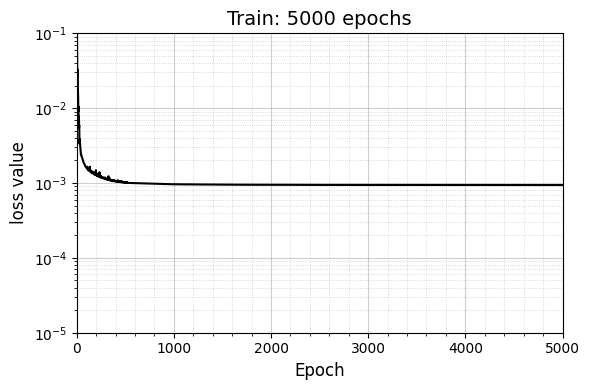

In [143]:
epochs = np.arange(len(rmsd_history))

plt.figure(figsize=(6, 4))

plt.plot(
    epochs,
    rmsd_history,
    color='black',
    linewidth=1.5
)

# Log scale
plt.yscale('log')

# Labels and title
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss value", fontsize=12)
plt.title("Train: 5000 epochs", fontsize=14)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8, alpha=0.6)
plt.grid(which='minor', linestyle=':', linewidth=0.6, alpha=0.6)

plt.xlim(0, 5000)
plt.ylim(1e-5, 1e-1)

plt.tight_layout()
plt.show()

# **DEEPONET**

In [144]:
class MLPNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_layers: List[int], output_dim: int, activation: nn.Module = nn.SiLU(), dtype: torch.dtype = torch.float64):
        super(MLPNetwork, self).__init__()
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, hidden_dim, dtype=dtype))
            layers.append(activation)
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim, dtype=dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [195]:
class DeepONetBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = MLPNetwork(
            input_dim=6,
            hidden_layers=[16,16,16],
            output_dim=4,
            activation=nn.SiLU(),
            dtype=torch.float32
        )

    def forward(self, x):
        return self.net(x)


In [196]:
class DeepONetTrunk(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = MLPNetwork(
            input_dim=2,
            hidden_layers=[16,16,16],
            output_dim=4,
            activation=nn.SiLU(),
            dtype=torch.float32
        )

    def forward(self, x):
        return self.net(x)


In [197]:
class DeepONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = DeepONetBranch()
        self.trunk = DeepONetTrunk()

    def forward(self, branch_input, trunk_input):
        """
        branch_input: (B, 6)
        trunk_input:  (B, N, 2)
        """
        B, N, _ = trunk_input.shape

        b = self.branch(branch_input)               # (B, 4)
        b = b.unsqueeze(1).expand(-1, N, -1)        # (B, N, 4)

        t = self.trunk(trunk_input.reshape(-1, 2))  # (B*N, 4)
        t = t.view(B, N, 4)

        ux_pred = torch.sum(b * t, dim=-1, keepdim=True)
        return ux_pred


In [199]:
model_2 = DeepONet().to(device)

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=500,
    gamma=0.5
)

epochs = 5000
rmsd_history_deeponet = []


In [108]:
def rmsd(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))


In [200]:
for epoch in range(epochs):
    model_2.train()
    optimizer.zero_grad()

    ux_pred = model_2(branch_train_t, trunk_train_t)
    loss = rmsd(ux_pred, ux_train_t)

    loss.backward()
    optimizer.step()
    scheduler.step()

    rmsd_history_deeponet.append(loss.item())

    if epoch % 500 == 0:
        print(f"[DeepONet] Epoch {epoch:4d} | RMSD: {loss.item():.6e}")


[DeepONet] Epoch    0 | RMSD: 8.383185e-02
[DeepONet] Epoch  500 | RMSD: 5.841556e-04
[DeepONet] Epoch 1000 | RMSD: 4.557415e-04
[DeepONet] Epoch 1500 | RMSD: 1.167192e-04
[DeepONet] Epoch 2000 | RMSD: 7.955372e-05
[DeepONet] Epoch 2500 | RMSD: 6.489767e-05
[DeepONet] Epoch 3000 | RMSD: 6.017848e-05
[DeepONet] Epoch 3500 | RMSD: 5.746968e-05
[DeepONet] Epoch 4000 | RMSD: 5.586913e-05
[DeepONet] Epoch 4500 | RMSD: 5.490200e-05


In [201]:
model_2.eval()
with torch.no_grad():
    ux_test_pred = model_2(branch_test_t, trunk_test_t)
    test_rmsd = rmsd(ux_test_pred, ux_test_t)

print(f"\n[DeepONet] Final Test RMSD: {test_rmsd.item():.6e}")



[DeepONet] Final Test RMSD: 5.517797e-05


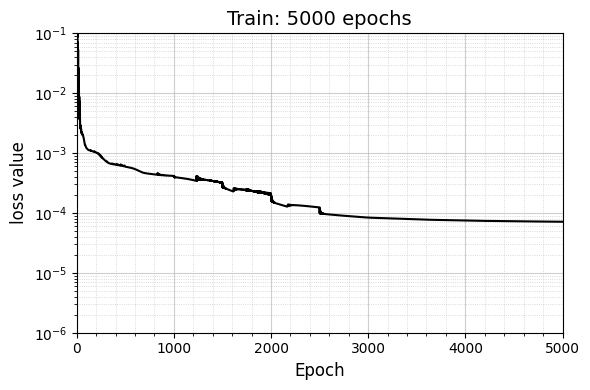

In [189]:
epochs_arr = np.arange(len(rmsd_history_deeponet))

plt.figure(figsize=(6, 4))

plt.plot(
    epochs_arr,
    rmsd_history_deeponet,
    color='black',
    linewidth=1.5
)

plt.yscale('log')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("loss value", fontsize=12)
plt.title("Train: 5000 epochs", fontsize=14)

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8, alpha=0.6)
plt.grid(which='minor', linestyle=':', linewidth=0.6, alpha=0.6)

plt.xlim(0, 5000)
plt.ylim(1e-6, 1e-1)

plt.tight_layout()
plt.show()

# **FOR 200 EPOCHS**

In [38]:
DeepoKAN_Loss_200=rmsd_history
DeepoNET_Loss_200_16_16=rmsd_history_deeponet

In [51]:
DeepoNET_Loss_200_16_16_16=rmsd_history_deeponet

In [65]:
DeepoNET_Loss_200_16_16_16_16=rmsd_history_deeponet

In [78]:
DeepoNET_Loss_200_64_64=rmsd_history_deeponet

# **FOR 1000 EPOCHS**

In [100]:
DeepoKAN_Loss_1000=rmsd_history
DeepoNET_Loss_1000_16_16=rmsd_history_deeponet

In [113]:
DeepoNET_Loss_1000_16_16_16=rmsd_history_deeponet

In [122]:
DeepoNET_Loss_1000_16_16_16_16=rmsd_history_deeponet

In [137]:
DeepoNET_Loss_1000_64_64=rmsd_history_deeponet

# **FOR 5000 EPOCHS**

In [156]:
DeepoKAN_Loss_5000=rmsd_history
DeepoNET_Loss_5000_16_16=rmsd_history_deeponet

In [203]:
DeepoNET_Loss_5000_16_16_16=rmsd_history_deeponet

In [179]:
DeepoNET_Loss_5000_16_16_16_16=rmsd_history_deeponet

In [190]:
DeepoNET_Loss_5000_64_64=rmsd_history_deeponet

# **PLOT**

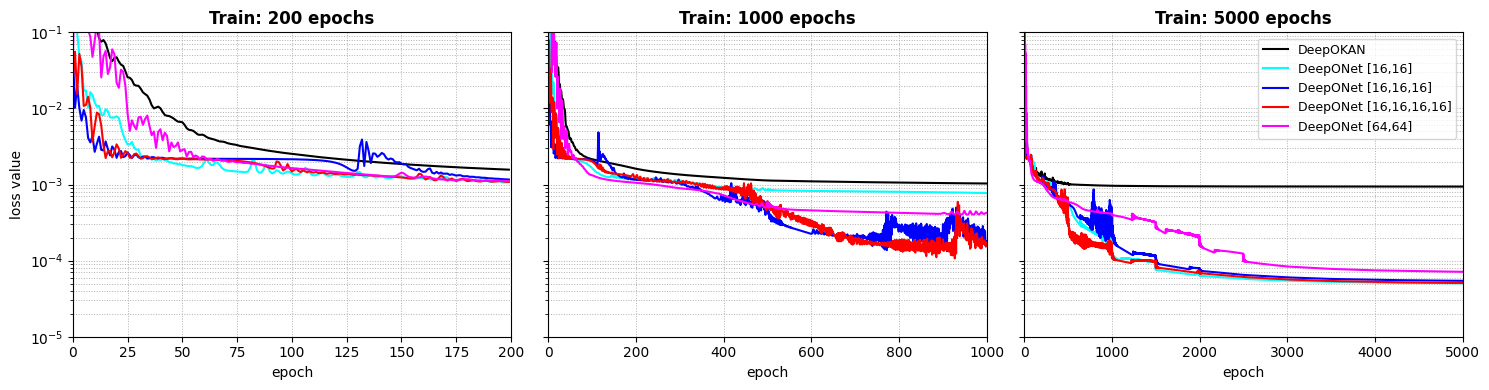

In [205]:
def plot_panel(ax, losses, title, max_epoch):
    for label, loss, color in losses:
        epochs = np.arange(len(loss))
        ax.plot(epochs, loss, label=label, linewidth=1.5, color=color)

    ax.set_yscale("log")
    ax.set_ylim(1e-5, 1e-1)
    ax.set_xlim(0, max_epoch)

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("epoch")
    ax.grid(True, which="both", linestyle=":", linewidth=0.7)


# ---------------------------
# Create figure with 3 subplots
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ---------------------------
# 200 epochs
# ---------------------------
losses_200 = [
    ("DeepOKAN", DeepoKAN_Loss_200, "black"),
    ("DeepONet [16,16]", DeepoNET_Loss_200_16_16, "cyan"),
    ("DeepONet [16,16,16]", DeepoNET_Loss_200_16_16_16, "blue"),
    ("DeepONet [16,16,16,16]", DeepoNET_Loss_200_16_16_16_16, "red"),
    ("DeepONet [64,64]", DeepoNET_Loss_200_64_64, "magenta"),
]

plot_panel(
    axes[0],
    losses_200,
    title="Train: 200 epochs",
    max_epoch=200
)

# ---------------------------
# 1000 epochs
# ---------------------------
losses_1000 = [
    ("DeepOKAN", DeepoKAN_Loss_1000, "black"),
    ("DeepONet [16,16]", DeepoNET_Loss_1000_16_16, "cyan"),
    ("DeepONet [16,16,16]", DeepoNET_Loss_1000_16_16_16, "blue"),
    ("DeepONet [16,16,16,16]", DeepoNET_Loss_1000_16_16_16_16, "red"),
    ("DeepONet [64,64]", DeepoNET_Loss_1000_64_64, "magenta"),
]

plot_panel(
    axes[1],
    losses_1000,
    title="Train: 1000 epochs",
    max_epoch=1000
)

# ---------------------------
# 5000 epochs
# ---------------------------
losses_5000 = [
    ("DeepOKAN", DeepoKAN_Loss_5000, "black"),
    ("DeepONet [16,16]", DeepoNET_Loss_5000_16_16, "cyan"),
    ("DeepONet [16,16,16]", DeepoNET_Loss_5000_16_16_16, "blue"),
    ("DeepONet [16,16,16,16]", DeepoNET_Loss_5000_16_16_16_16, "red"),
    ("DeepONet [64,64]", DeepoNET_Loss_5000_64_64, "magenta"),
]

plot_panel(
    axes[2],
    losses_5000,
    title="Train: 5000 epochs",
    max_epoch=5000
)

# ---------------------------
# Labels & legend
# ---------------------------
axes[0].set_ylabel("loss value")

# Legend only on last plot (like your image)
axes[2].legend(
    loc="upper right",
    fontsize=9,
    frameon=True
)

plt.tight_layout()
plt.show()
